In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import joblib

In [2]:
domain = pd.read_csv("dataset/cleaned/domain_nsw.csv")
nsw = pd.read_csv("dataset/cleaned/nsw.csv")

In [3]:
print(f"Domain shape: {domain.shape}")
print(f"NSW shape: {nsw.shape}")

Domain shape: (7913, 20)
NSW shape: (1553001, 15)


In [4]:
domain.columns = [c.lower().replace(" ", "_") for c in domain.columns]
nsw.columns = [c.lower().replace(" ", "_") for c in nsw.columns]

In [5]:
nsw = nsw.rename(columns={
    'property_unit_number': 'unit',
    'property_house_number': 'street_number',
    'property_street_name': 'street_name',
    'property_locality': 'suburb',
    'property_post_code': 'postcode',
    'area': 'size',
    'price_per_m2': 'price_per_m2',
    'purchase_price': 'price',
    'source': 'source'
})

In [6]:
common_cols = set(domain.columns) | set(nsw.columns)  

for col in common_cols:
    if col not in domain.columns:
        domain[col] = pd.NA
    if col not in nsw.columns:
        nsw[col] = pd.NA

In [7]:
domain = domain[sorted(common_cols)]
nsw = nsw[sorted(common_cols)]

In [8]:
merged = pd.concat([domain, nsw], ignore_index=True)

C:\Users\quock\AppData\Local\Temp\ipykernel_60040\2294227190.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged = pd.concat([domain, nsw], ignore_index=True)


In [9]:
merged["price_per_m2"] = np.where(
    (merged["size"].isna()) | (merged["size"] == 0),
    np.nan,
    merged["price"] / merged["size"]
)

merged["price_per_m2"] = merged["price_per_m2"].replace([np.inf, -np.inf], np.nan)
merged["price_per_m2"] = merged["price_per_m2"].fillna(merged["price_per_m2"].median())

In [10]:
df = merged.drop(columns=['address', 'address_url', 'sale_counter', 'state', 'contract_date', 'dealing_number', 'format', 'lot_number', 'unit'])

In [11]:
df.shape

(1560914, 18)

In [12]:
df.columns

Index(['area_type', 'baths', 'beds', 'dist_to_sydney', 'lat', 'lon',
       'nature_of_property', 'parking', 'postcode', 'price', 'price_per_m2',
       'primary_purpose', 'size', 'street_name', 'street_number', 'suburb',
       'type', 'zoning'],
      dtype='object')

In [13]:
df.isna().sum()

area_type                7913
baths                 1553001
beds                  1553001
dist_to_sydney        1553001
lat                   1553001
lon                   1553001
nature_of_property       7913
parking               1553001
postcode                    0
price                       0
price_per_m2                0
primary_purpose          8140
size                        0
street_name               669
street_number           31732
suburb                      0
type                  1553001
zoning                   7913
dtype: int64

In [14]:
df['has_location'] = df['lat'].notna().astype(int)

In [15]:
for col in ['lat', 'lon', 'dist_to_sydney']:
    if col in df.columns:
        df[col] = df[col].fillna(0)

In [16]:
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(exclude=[np.number]).columns

In [17]:
for col in num_cols:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

In [18]:
for col in cat_cols:
    df[col] = df[col].fillna("unknown")

In [19]:
df.isna().sum()

area_type             0
baths                 0
beds                  0
dist_to_sydney        0
lat                   0
lon                   0
nature_of_property    0
parking               0
postcode              0
price                 0
price_per_m2          0
primary_purpose       0
size                  0
street_name           0
street_number         0
suburb                0
type                  0
zoning                0
has_location          0
dtype: int64

## Train models

In [20]:
X = df.drop(columns=['price'])
y = df['price']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [22]:
num_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = X.select_dtypes(exclude=[np.number]).columns

In [23]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='drop'
)

In [24]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001, max_iter=10000),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

In [24]:
results = []

### 1. LINEAR REGRESSION

In [28]:
print("\n===== Training Linear Regression =====")

lr_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

lr_pipe.fit(X_train, y_train)
y_pred_lr = lr_pipe.predict(X_test)
lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_r2 = r2_score(y_test, y_pred_lr)

print(f"Linear Regression → MAE={lr_mae:.2f}, RMSE={lr_rmse:.2f}, R2={lr_r2:.4f}")
results.append(['Linear Regression', lr_mae, lr_rmse, lr_r2])


===== Training Linear Regression =====
Linear Regression → MAE=490522.15, RMSE=881730.26, R2=0.2306


### 2. DECISION TREE

In [29]:
print("\n===== Training Decision Tree =====")

dt_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

dt_pipe.fit(X_train, y_train)
y_pred_dt = dt_pipe.predict(X_test)
dt_mae = mean_absolute_error(y_test, y_pred_dt)
dt_rmse = np.sqrt(mean_squared_error(y_test, y_pred_dt))
dt_r2 = r2_score(y_test, y_pred_dt)

print(f"Decision Tree → MAE={dt_mae:.2f}, RMSE={dt_rmse:.2f}, R2={dt_r2:.4f}")
results.append(['Decision Tree', dt_mae, dt_rmse, dt_r2])


===== Training Decision Tree =====
Decision Tree → MAE=61092.36, RMSE=314125.93, R2=0.9023


### 3. RANDOM FOREST

In [30]:
print("\n===== Training Random Forest =====")

rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])

rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)

print(f"Random Forest → MAE={rf_mae:.2f}, RMSE={rf_rmse:.2f}, R2={rf_r2:.4f}")
results.append(['Random Forest', rf_mae, rf_rmse, rf_r2])


===== Training Random Forest =====
Random Forest → MAE=56591.62, RMSE=302163.56, R2=0.9096


### 4. GRADIENT BOOSTING

In [25]:
print("\n===== Training Gradient Boosting =====")

gb_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(
        n_estimators=500,      
        learning_rate=0.05,    
        max_depth=5,           
        min_samples_split=10,  
        min_samples_leaf=4,
        random_state=42
    ))
])

gb_pipe.fit(X_train, y_train)
y_pred_gb = gb_pipe.predict(X_test)
gb_mae = mean_absolute_error(y_test, y_pred_gb)
gb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb))
gb_r2 = r2_score(y_test, y_pred_gb)

print(f"Gradient Boosting → MAE={gb_mae:.2f}, RMSE={gb_rmse:.2f}, R2={gb_r2:.4f}")
results.append(['Gradient Boosting', gb_mae, gb_rmse, gb_r2])


===== Training Gradient Boosting =====
Gradient Boosting → MAE=110292.31, RMSE=427244.49, R2=0.8193


### 5. XGBOOST

In [26]:
print("\n===== Training XGBoost =====")

xgb_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(
        n_estimators=10000,
        learning_rate=0.001,
        max_depth=8,
        subsample=0.7,
        colsample_bytree=0.7,
        min_child_weight=10,
        reg_lambda=2,
        reg_alpha=1,
        random_state=42,
        n_jobs=-1,
        tree_method='hist'
    ))
])

xgb_pipe.fit(X_train, y_train)
y_pred_xgb = xgb_pipe.predict(X_test)
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
xgb_r2 = r2_score(y_test, y_pred_xgb)

print(f"XGBoost → MAE={xgb_mae:.2f}, RMSE={xgb_rmse:.2f}, R2={xgb_r2:.4f}")
results.append(['XGBoost', xgb_mae, xgb_rmse, xgb_r2])


===== Training XGBoost =====
XGBoost → MAE=117768.63, RMSE=425141.32, R2=0.8211


In [31]:
results_df = pd.DataFrame(results, columns=['Model', 'MAE', 'RMSE', 'R2'])
print("\n===== Tổng hợp kết quả =====")
print(results_df)


===== Tổng hợp kết quả =====
               Model            MAE           RMSE        R2
0  Gradient Boosting  110292.306601  427244.488163  0.819349
1            XGBoost  117768.625833  425141.322078  0.821123
2  Linear Regression  490522.147295  881730.262198  0.230587
3      Decision Tree   61092.359804  314125.928660  0.902345
4      Random Forest   56591.616101  302163.561971  0.909641


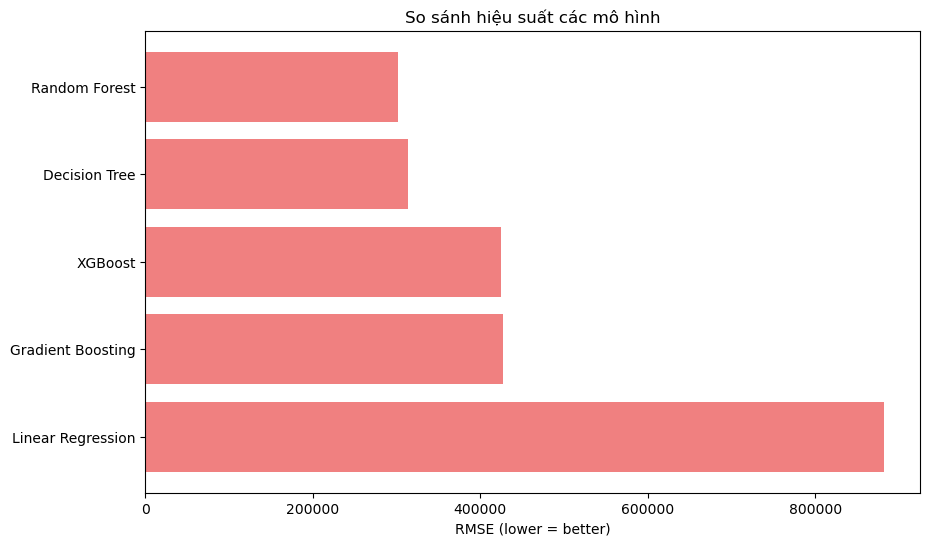


📊 Kết quả tổng hợp:
            Model           MAE          RMSE       R2
    Random Forest  56591.616101 302163.561971 0.909641
    Decision Tree  61092.359804 314125.928660 0.902345
          XGBoost 117768.625833 425141.322078 0.821123
Gradient Boosting 110292.306601 427244.488163 0.819349
Linear Regression 490522.147295 881730.262198 0.230587


In [ ]:
results_df = pd.DataFrame(results, columns=['Model', 'MAE', 'RMSE', 'R2']).sort_values(by='RMSE')

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.barh(results_df['Model'], results_df['RMSE'], color='lightcoral')
plt.xlabel('RMSE (lower = better)')
plt.title('So sánh hiệu suất các mô hình')
plt.gca().invert_yaxis()
plt.show()

# In bảng kết quả
print("\n📊 Kết quả tổng hợp:")
print(results_df.to_string(index=False))


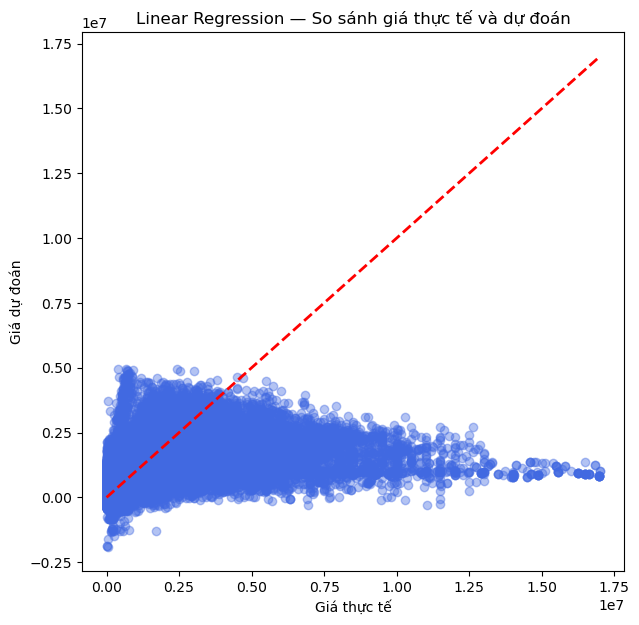

In [38]:
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred_lr, alpha=0.4, color='royalblue')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel('Giá thực tế')
plt.ylabel('Giá dự đoán')
plt.title('Linear Regression — So sánh giá thực tế và dự đoán')
plt.show()

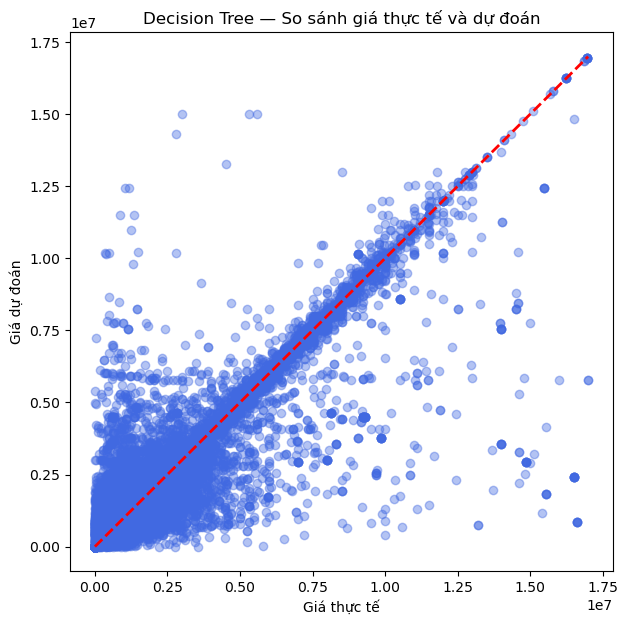

In [39]:
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred_dt, alpha=0.4, color='royalblue')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel('Giá thực tế')
plt.ylabel('Giá dự đoán')
plt.title('Decision Tree — So sánh giá thực tế và dự đoán')
plt.show()

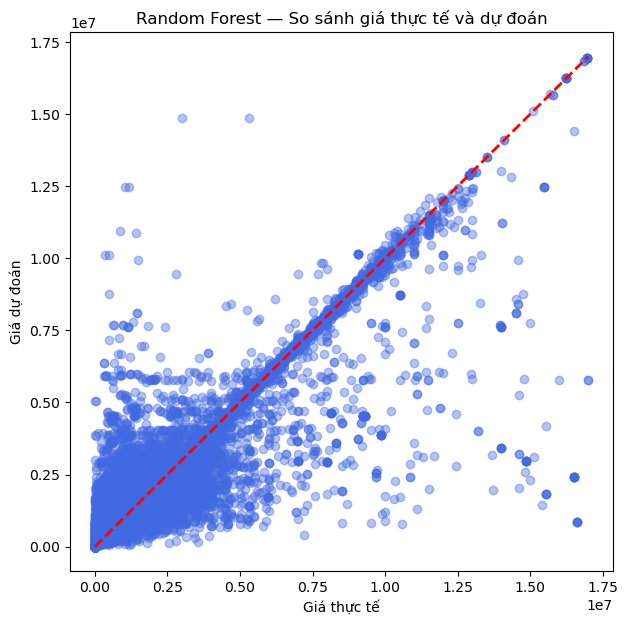

In [40]:
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred_rf, alpha=0.4, color='royalblue')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel('Giá thực tế')
plt.ylabel('Giá dự đoán')
plt.title('Random Forest — So sánh giá thực tế và dự đoán')
plt.show()

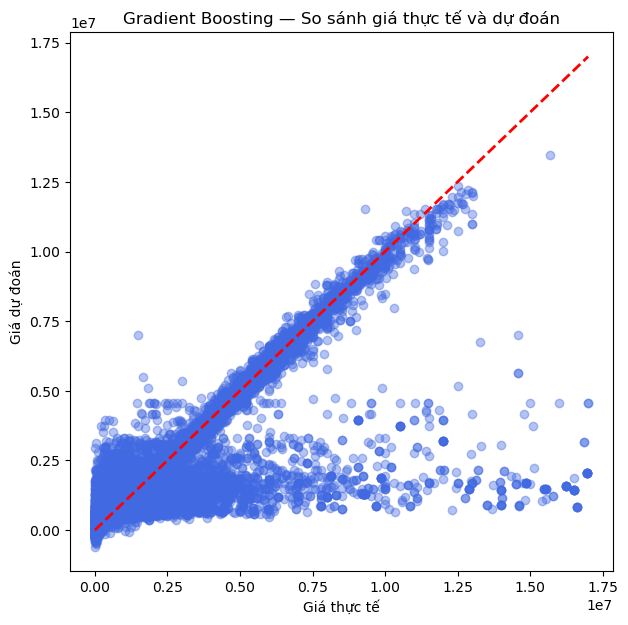

In [41]:
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred_gb, alpha=0.4, color='royalblue')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel('Giá thực tế')
plt.ylabel('Giá dự đoán')
plt.title('Gradient Boosting — So sánh giá thực tế và dự đoán')
plt.show()

In [ ]:
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred_xgb, alpha=0.4, color='royalblue')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel('Giá thực tế')
plt.ylabel('Giá dự đoán')
plt.title('XGBoost — So sánh giá thực tế và dự đoán')
plt.show()